In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
from astropy.table import Table as at
import astropy.units as u
from astropy.modeling import models, fitting
import astropy.constants as const
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.integrate import simpson 
import pandas as pd 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from astropy.constants import c  

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [3]:
#this is a little messy, i threw stuff in here as i was debugging its not in any consistent order really
#also i had to change a decent amt from hwk 1 so i hope i did that one right
#Sorry joseph, if you get a headache from this ill bring you a snack (NOT BRIBERY JUST KINDESS)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
c = c.to(u.micron / u.s)
magjanks = 3631 * u.Jy  
color_palette = ['blue', 'deepskyblue', 'cyan', 'lime', 'yellowgreen', 'gold', 'orange', 
                 'darkorange', 'red', 'firebrick', 'darkred', 'brown']
#Data loading
def load_sed_data(filename):
    sed_data = at.read(filename, format='ascii', 
                       names=['wave', 'fnu', 'fnu_bright', 'fnu_faint'], 
                       data_start=1)
    sed_data["wave"] = sed_data["wave"] * u.micron
    sed_data["fnu"] = sed_data["fnu"] * u.mJy 
    return sed_data

def load_lsst_data(bands):
    filter_data = {}
    for band in bands:
        filename = f'LSST_LSST.{band}_filter.dat'
        filter_info = np.loadtxt(filename, delimiter=' ', skiprows=1)
        wavelengths_microns = filter_info[:, 0] * u.Angstrom.to(u.micron) 
        transmissions = filter_info[:, 1]
        filter_data[band] = {'wavelengths': wavelengths_microns, 'transmissions': transmissions}
    return filter_data

#Function for redshifing throughout
def redshift_sed(wavelength, fluxdensity, redshift):
    if np.isscalar(redshift):
        luminosity_distance = cosmo.luminosity_distance(redshift).to(u.pc)
        dimming = ((10 * u.pc) / luminosity_distance) ** 2 / (1 + redshift)
        wavelength_z = wavelength * (1 + redshift)
        flux_densityz = fluxdensity * dimming
    else: #literally couldnt get fig 3 to work without using arrays??? skill issue fs :/
        #probably coudlve found a way to combo this redshift so theres no scalar vs array 
        #and also so that way theres 1 k correction defined, maybe a class wouldve worked
        #ik im being lazy but this was quicker for me 
        redshift = np.array(redshift)[:, np.newaxis] 
        wavelength_z = wavelength * (1 + redshift)
        luminosity_distances = cosmo.luminosity_distance(redshift.flatten()).to(u.pc).value
        dimmings = ((10 * u.pc.to(u.cm)) / luminosity_distances[:, np.newaxis]) ** 2 / (1 + redshift)
        flux_densityz = fluxdensity * dimmings

    return wavelength_z, flux_densityz

#Conversion
def flambda(wavelength, fluxdensity):
    return (c / (wavelength ** 2)) * fluxdensity 

def absmag(wavelength):
    frequency = c / wavelength  
    return (frequency ** 2 / c) * magjanks.to(u.mJy).value 

def compute_fluxdensity(sedwave, sed_flux, band):
    sed_interpolated = np.interp(band[:, 0], sedwave, sed_flux)
    freq = c / band[:, 0]
    fluxint = integrate.simpson(freq**2 / c * sed_interpolated * band[:, 1] * band[:, 0], band[:, 0])
    norm = integrate.simpson(band[:, 1] * band[:, 0], band[:, 0])
    return fluxint / norm

#getting closest band to wavelen
def closebands(lsst_data, observer_bandwave, redshift):
    diffarray = []
    redshifted_waves = observer_bandwave / (1 + redshift)
    
    for band in lsst_data:
        rest_bandwave = lsst_data[band]['wavelengths']
        if len(rest_bandwave) != len(redshifted_waves):
            rest_bandwaveinterp = np.interp(redshifted_waves, rest_bandwave, rest_bandwave)
        else:
            rest_bandwaveinterp = rest_bandwave
        diffarray.append(np.abs(redshifted_waves - rest_bandwaveinterp).sum())

    selected_rest_band = list(lsst_data.keys())[np.argmin(diffarray)]
    return selected_rest_band

#nastiness like truly the ugliest thing ive had to think about but ik it gets worse :p
def calculate_kcorrect(lsst_data, sed_data, z_array, usebands): #this works for fig 3
    zwaves, zflux = redshift_sed(sed_data["wave"], sed_data["fnu"], z_array)
    
    observer_bandwaves = [lsst_data[band]['wavelengths'] for band in usebands]
    observer_bandtrans = [lsst_data[band]['transmissions'] for band in usebands]
    observer_bandab = [absmag(wave) for wave in observer_bandwaves]
    
    K_corrections = np.zeros((len(usebands), len(z_array)))  # preallocation
    
    for k, (wave, trans) in enumerate(zip(observer_bandwaves, observer_bandtrans)):
        sed_obs_bandflux = np.array([
            flambda(wave, np.interp(wave, zwaves[j], zflux[j], left=0, right=0))
            for j in range(len(z_array))
        ])
        
        for j, z in enumerate(z_array):
            rest_band = closebands(lsst_data, wave, z)
            rest_bandwave = lsst_data[rest_band]['wavelengths']
            rest_bandtrans = lsst_data[rest_band]['transmissions']
            
            sed_restband_flux = flambda(
                rest_bandwave, 
                np.interp(rest_bandwave * (1 + z), zwaves[j], zflux[j], left=0, right=0)
            )
            rest_band_ab = absmag(rest_bandwave)

            K_corrections[k, j] = compute_kcorrect(
                wave, trans, rest_bandwave, rest_bandtrans,
                sed_obs_bandflux[j], sed_restband_flux, observer_bandab[k], rest_band_ab, z
            )

    return K_corrections, z_array, usebands

def compute_kcorrect(observer_bandwave, observer_bandtrans, rest_bandwave, rest_bandtrans, #works for fig 1
                        sed_obs_bandflux, sed_restband_flux, observer_bandab, rest_band_ab, z):
    integral_obsflux = integrate.simpson(sed_obs_bandflux * observer_bandwave * observer_bandtrans, observer_bandwave)
    integral_restflux = integrate.simpson(sed_restband_flux * rest_bandwave * rest_bandtrans, rest_bandwave)
    integral_obsab = integrate.simpson(observer_bandab * observer_bandwave * observer_bandtrans, observer_bandwave)
    integral_restab = integrate.simpson(rest_band_ab * rest_bandwave * rest_bandtrans, rest_bandwave)

    if integral_obsflux == 0 or integral_restflux == 0 or integral_obsab == 0 or integral_restab == 0:
        return np.nan
    return -2.5 * np.log10((1 / (1 + z)) * (integral_obsflux * integral_restab) / (integral_obsab * integral_restflux))

#Dont you just hate when the maps you want to use doesnt look right
def truncatemap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(f'trunc({cmap.name},{minval:.2f},{maxval:.2f})', cmap(np.linspace(minval, maxval, n)))
    return new_cmap


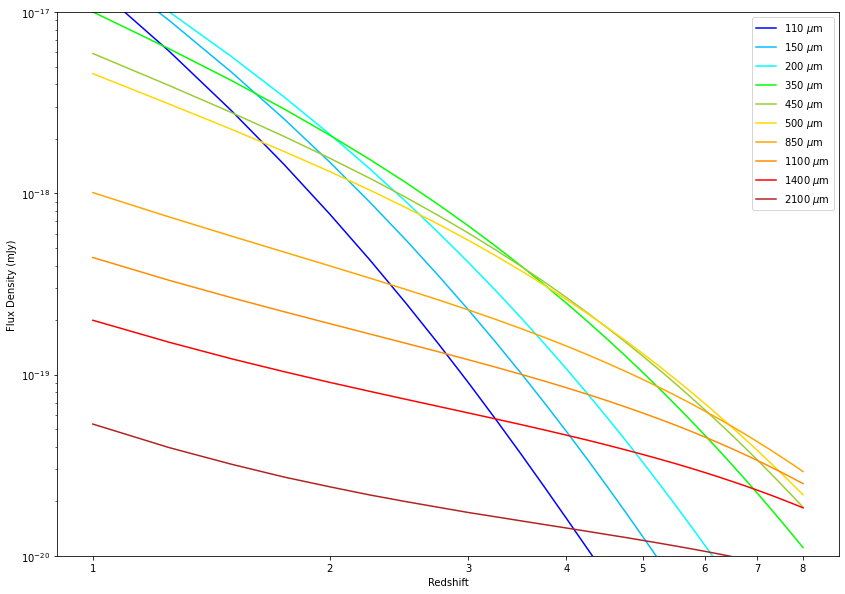

In [4]:
#Figure1
sed_info = load_sed_data('aless_average_seds.dat')
lambda_vals = np.array(sed_info['wave'])
flux_vals = np.array(sed_info['fnu'])

redshift_range = np.arange(1, 8.25, 0.25)
commonbands = np.array([110, 150, 200, 350, 450, 500, 850, 1100, 1400, 2100])

flux_matrix = np.zeros((len(commonbands), len(redshift_range)))

plt.figure(figsize=(14, 10))

bandwidth_factor = 0.015 #actually had to pull out pen and paper to think about fig1
filter_bands = [np.linspace(commonband - commonband * bandwidth_factor, commonband + commonband * bandwidth_factor, int(commonband)) for commonband in commonbands]
filter_bandtrans = [np.exp(-0.5 * ((filter_band - commonband) / (0.005 * commonband))**2) for filter_band, commonband in zip(filter_bands, commonbands)]

for ind, commonband in enumerate(commonbands):
    filter_band = np.column_stack((filter_bands[ind], filter_bandtrans[ind]))
    
    for z_ind, redshift in enumerate(redshift_range):
        zwave, zflux = redshift_sed(lambda_vals, flux_vals, redshift)
        flux_density = compute_fluxdensity(zwave, zflux, filter_band)
        flux_matrix[ind, z_ind] = flux_density * commonband**2 / c.value
    
    plt.plot(redshift_range, flux_matrix[ind], label=f"{commonband} $\\mu$m", color=color_palette[ind])

plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Flux Density (mJy)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20, 1e-17)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], [str(i) for i in range(1, 9)])

plt.show()



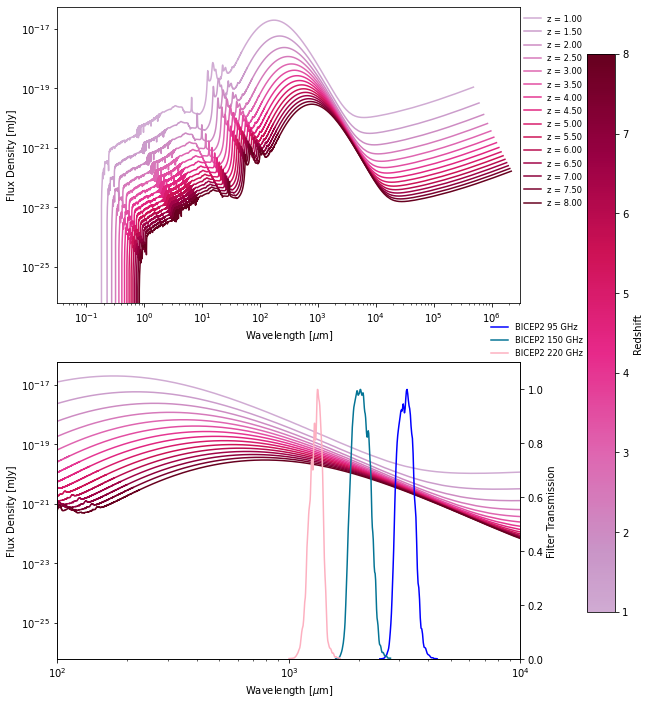

In [5]:
# Plotting for Figure 2

sed_data = load_sed_data('aless_average_seds.dat')
wavelength = np.array(sed_data['wave'])
fluxdensity = np.array(sed_data['fnu'])

B95GHz = np.loadtxt('BICEP_BICEP2.95GHz_rj.dat', usecols=[0, 1])
B150GHz = np.loadtxt('BICEP_BICEP2.150GHz_rj.dat', usecols=[0, 1])
B220GHz = np.loadtxt('BICEP_BICEP2.220GHz_rj.dat', usecols=[0, 1])

B95GHz[:, 0] = (B95GHz[:, 0] * u.angstrom).to(u.micron).value
B150GHz[:, 0] = (B150GHz[:, 0] * u.angstrom).to(u.micron).value
B220GHz[:, 0] = (B220GHz[:, 0] * u.angstrom).to(u.micron).value

truncatedcmap = truncatemap(plt.cm.PuRd, 0.3, 1.0) # Truncated bc its ugly otherwise
redshifts = np.arange(1, 8.5, 0.50) #assuming were keeping inclusivity for f1 thru f3
color_map = truncatedcmap(np.linspace(0, 1, len(redshifts)))

fig, (ax3, ax1) = plt.subplots(2, 1, figsize=(10, 12))

for i, z in enumerate(redshifts):
    redshifted_wave, redshifted_flux = redshift_sed(wavelength, fluxdensity, z)
    ax1.loglog(redshifted_wave, redshifted_flux, color=color_map[i], label=f'z = {z:.2f}')
    ax3.loglog(redshifted_wave, redshifted_flux, color=color_map[i], label=f'z = {z:.2f}')

ax1.set_xlabel('Wavelength [$\\mu$m]')
ax1.set_ylabel('Flux Density [mJy]')
ax1.set_xlim(10**2, 10**4)

ax2 = ax1.twinx()
ax2.plot(B95GHz[:, 0], B95GHz[:, 1], color='blue', linestyle='-', label='BICEP2 95 GHz')
ax2.plot(B150GHz[:, 0], B150GHz[:, 1], color='#047495', linestyle='-', label='BICEP2 150 GHz')
ax2.plot(B220GHz[:, 0], B220GHz[:, 1], color='#fdb0c0', linestyle='-', label='BICEP2 220 GHz')

ax2.set_ylabel('Filter Transmission')
ax2.set_ylim(0, 1.1)
ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1.16), frameon=False, fontsize='small')

ax3.set_xlabel('Wavelength [$\\mu$m]')
ax3.set_ylabel('Flux Density [mJy]')
ax3.legend(loc='upper right', bbox_to_anchor=(1.15, 1), frameon=False, fontsize='small')
ax3.set_xlim(10**(-1.5), 10**(6.5))

fig.colorbar(plt.cm.ScalarMappable(cmap=truncatedcmap, norm=plt.Normalize(vmin=min(redshifts), vmax=max(redshifts))),
             ax=[ax1, ax3], orientation='vertical', pad=0.12, fraction=0.05, label='Redshift')

plt.show()


/var/folders/7w/tjwz_8cs4_s5tmwrjlrv2kdr0000gn/T/ipykernel_16609/2848138092.py:42: RuntimeWarning: divide by zero encountered in divide
  dimmings = ((10 * u.pc.to(u.cm)) / luminosity_distances[:, np.newaxis]) ** 2 / (1 + redshift)
/var/folders/7w/tjwz_8cs4_s5tmwrjlrv2kdr0000gn/T/ipykernel_16609/2848138092.py:43: RuntimeWarning: invalid value encountered in multiply
  flux_densityz = fluxdensity * dimmings
/var/folders/7w/tjwz_8cs4_s5tmwrjlrv2kdr0000gn/T/ipykernel_16609/2848138092.py:121: RuntimeWarning: invalid value encountered in scalar divide
  return -2.5 * np.log10((1 / (1 + z)) * (integral_obsflux * integral_restab) / (integral_obsab * integral_restflux))
/var/folders/7w/tjwz_8cs4_s5tmwrjlrv2kdr0000gn/T/ipykernel_16609/2848138092.py:114: RuntimeWarning: invalid value encountered in multiply
  integral_obsflux = integrate.simpson(sed_obs_bandflux * observer_bandwave * observer_bandtrans, observer_bandwave)
/opt/anaconda3/envs/jupyter/lib/python3.10/site-packages/astropy/units/qua

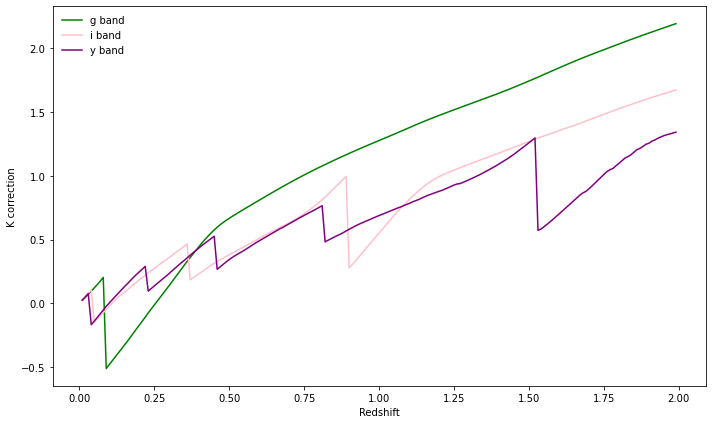

In [6]:
#Figure 3 : honestly wth

sed_data = load_sed_data('aless_average_seds.dat')
lsst_data = load_lsst_data(['g', 'i', 'r', 'u', 'y', 'z'])
z_grid = np.arange(0, 2, 0.01)
observer_frame_bands = ["g", "i", "y"]
band_colors = ['green', 'pink', 'purple']

K_corrections, z_grid, observer_frame_bands = calculate_kcorrect(lsst_data, sed_data, z_grid, observer_frame_bands)
plt.figure(figsize=(10, 6))

for k, band in enumerate(observer_frame_bands):
    plt.plot(z_grid, K_corrections[k], label=f"{band} band", color=band_colors[k])

plt.ylabel("K correction")
plt.xlabel("Redshift")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

,N,Mean Dist (Mpc),Avg Mag (All),Avg Mag (Detected),Peculiar Vel Impact(%),$H_{{0}}$ Mag Est (km/s/Mpc),$H_{{0}}$ Mag Bias (km/s/Mpc),$H_{{0}}$ Hub Est (km/s/Mpc),$H_{{0}}$ Hub Bias (km/s/Mpc)
0,100,1909.76,22.25,20.17,0.29,121.33,49.33,72.53,0.53


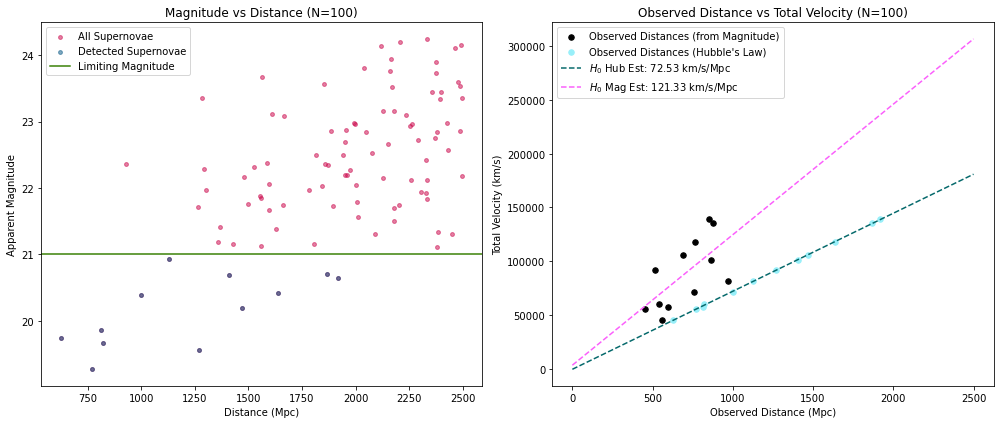

,N,Mean Dist (Mpc),Avg Mag (All),Avg Mag (Detected),Peculiar Vel Impact(%),$H_{{0}}$ Mag Est (km/s/Mpc),$H_{{0}}$ Mag Bias (km/s/Mpc),$H_{{0}}$ Hub Est (km/s/Mpc),$H_{{0}}$ Hub Bias (km/s/Mpc)
0,1000,1891.74,22.31,20.21,0.36,81.81,9.81,72.05,0.05


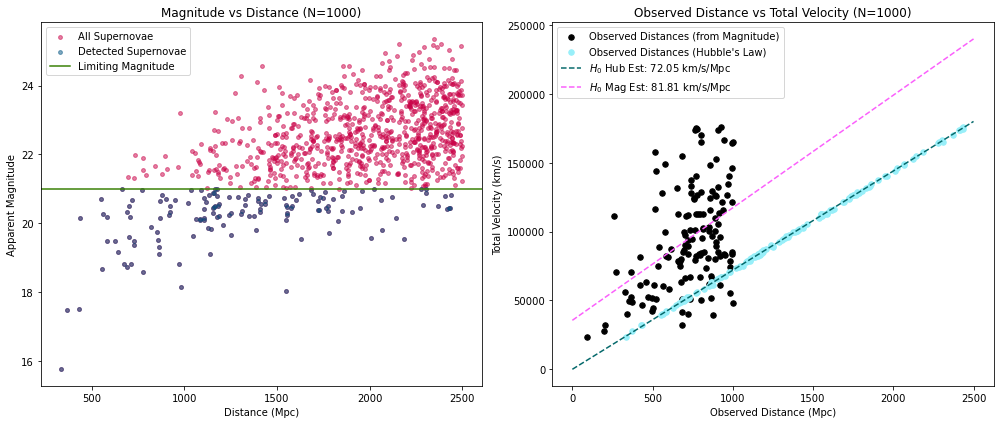

,N,Mean Dist (Mpc),Avg Mag (All),Avg Mag (Detected),Peculiar Vel Impact(%),$H_{{0}}$ Mag Est (km/s/Mpc),$H_{{0}}$ Mag Bias (km/s/Mpc),$H_{{0}}$ Hub Est (km/s/Mpc),$H_{{0}}$ Hub Bias (km/s/Mpc)
0,10000,1875.52,22.27,20.20,0.35,103.13,31.13,71.99,-0.01


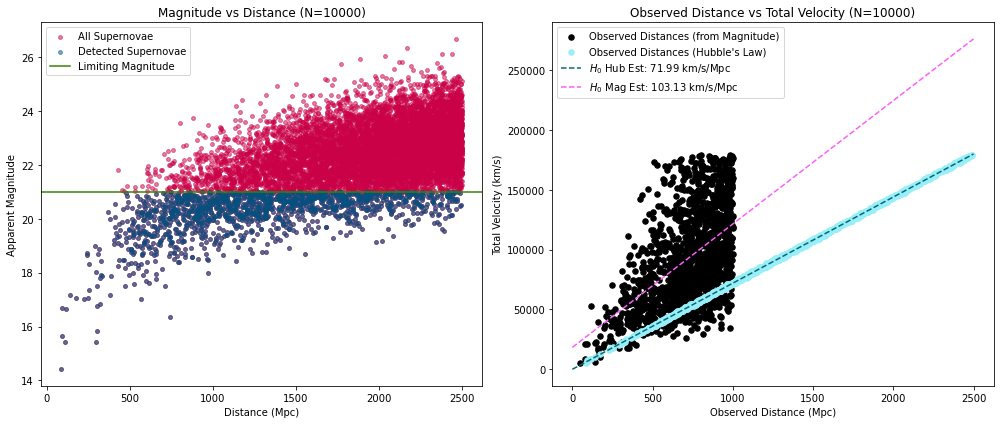

In [10]:
#figure Q2 This was the first one i solved i loved this one tbh,
#except pt3 instructions are kinda unclear so i gave my best interpretation 

H0_true = 72 * (u.km / u.s / u.Mpc)
cosmo = FlatLambdaCDM(H0=H0_true, Om0=0.3) 
M_real = -19
peculiar_velstd = 600 * (u.km / u.s)
limiting_magnitude = 21
max_distance = 2500

def generate_distances(N, max_distance):
    distances = max_distance * np.cbrt(np.random.uniform(0, 1, N))
    return distances * u.Mpc

def calculate_magnitudes(distances, M_real, scatter=1):
    distances_pc = distances.to(u.pc).value
    M = M_real + np.random.normal(0, scatter, len(distances_pc))
    magnitudes = M + 5 * np.log10(distances_pc) - 5
    return magnitudes

def filter_detected_supernovae(magnitudes, limiting_magnitude):
    detected_mask = (magnitudes <= limiting_magnitude)
    return detected_mask

def calculate_velocities(distances, H0_true, peculiar_velstd):
    recession_velocities = (H0_true * distances).to(u.km / u.s)
    peculiar_velocities = np.random.normal(0, peculiar_velstd.value, len(distances)) * u.km / u.s
    totalvel = recession_velocities + peculiar_velocities
    return totalvel, recession_velocities, peculiar_velocities

def calculate_observed_distances_Hubble(totalvel, cosmo):
    c = 299792.458 * u.km / u.s  
    z_observed = (totalvel / c).decompose() 
    
    observed_distances = cosmo.luminosity_distance(z_observed)
    return observed_distances.to(u.Mpc)

def calculate_observed_distances_Magnitude(magnitudes, M_real):
    distances_pc = 10 ** ((magnitudes - M_real + 5) / 5)
    observed_distances = (distances_pc * u.pc).to(u.Mpc)
    return observed_distances

def calculate_H0(detected_distances, totalvel):
    linear_model = models.Linear1D(intercept=0)
    fitter = fitting.LinearLSQFitter()
    fit = fitter(linear_model, detected_distances.value, totalvel.value)
    H0_estimated = fit.slope * (u.km / u.s / u.Mpc)
    return H0_estimated, fit

def table(N, mean_distance, avg_magnitude_all, avg_magnitude_detected, peculiar_impact, H0_magnitude_estimate, H0_bias_magnitude, H0_hubble_estimate, H0_bias_hubble):
    data = {
        'N': [N],
        'Mean Dist (Mpc)': [f"{mean_distance:.2f}"],
        'Avg Mag (All)': [f"{avg_magnitude_all:.2f}"],
        'Avg Mag (Detected)': [f"{avg_magnitude_detected:.2f}"],
        'Peculiar Vel Impact(%)': [f"{peculiar_impact:.2f}"],
        '$H_{{0}}$ Mag Est (km/s/Mpc)': [f"{H0_magnitude_estimate:.2f}"],
        '$H_{{0}}$ Mag Bias (km/s/Mpc)': [f"{H0_bias_magnitude:.2f}"],
        '$H_{{0}}$ Hub Est (km/s/Mpc)': [f"{H0_hubble_estimate:.2f}"],
        '$H_{{0}}$ Hub Bias (km/s/Mpc)': [f"{H0_bias_hubble:.2f}"]
    }
    
    df = pd.DataFrame(data) 
    styled_df = (df.style
                 .set_caption(f"Supernova Simulation Results for N={N}")  
                 .set_properties(**{
                     'text-align': 'center',
                     'color': 'black', 
                     'font-size': '12px'
                 })
                 .set_table_styles([{
                     'selector': 'caption',
                     'props': [('color', 'deeppink'), ('font-size', '16px')]
                 }, {
                     'selector': 'th',
                     'props': [('background-color', 'white'), ('color', 'black')]
                 }, {
                     'selector': 'td',
                     'props': [('padding', '5px')]
                 }])
                 )
    
    display(styled_df)

def montecarlo_sim(N, max_distance, M_real, limiting_magnitude):
    distances = generate_distances(N, max_distance)
    magnitudes = calculate_magnitudes(distances, M_real, scatter=1)
    detected_mask = filter_detected_supernovae(magnitudes, limiting_magnitude)
    detected_distances = distances[detected_mask]
    detected_magnitudes = magnitudes[detected_mask]
    totalvel, recession_vel, peculiar_vel = calculate_velocities(distances, H0_true, peculiar_velstd)
    totalvel_detected = totalvel[detected_mask]
    observed_distances = calculate_observed_distances_Hubble(totalvel, cosmo) 
    observed_distances_detected = observed_distances[detected_mask]
    
    return distances, magnitudes, detected_magnitudes, detected_distances, totalvel, totalvel_detected, recession_vel, peculiar_vel, observed_distances_detected

def runsim(N, max_distance):
    distances, magnitudes, detected_magnitudes, detected_distances, totalvel, totalvel_detected, recession_vel, peculiar_vel, observed_distances = montecarlo_sim(N, max_distance, M_real, limiting_magnitude)
    
    totalvel_detected = totalvel_detected.to(u.km / u.s)
    totalvel = totalvel.to(u.km / u.s)
    
    mean_distance = np.mean(distances).value
    avg_magnitude_all = np.mean(magnitudes)
    avg_magnitude_detected = np.mean(detected_magnitudes)
    
    H0_estimated_detected, fit_detected = calculate_H0(detected_distances, totalvel_detected)
    
    linear_model = models.Linear1D(intercept=0)
    fitter = fitting.LinearLSQFitter()
    fit_observed = fitter(linear_model, calculate_observed_distances_Magnitude(detected_magnitudes, M_real).value, totalvel_detected.value)
    
    peculiar_impact = (np.mean(np.abs(peculiar_vel)) / np.mean(recession_vel)) * 100
    H0_magnitude_estimate = fit_observed.slope.value
    H0_bias_magnitude = H0_magnitude_estimate - H0_true.value
    
    linear_model_hubble = models.Linear1D(intercept=0)
    fit_hubble = fitter(linear_model_hubble, detected_distances.value, totalvel_detected.value)
    H0_hubble_estimate = fit_hubble.slope * (u.km / u.s / u.Mpc)
    H0_bias_hubble = H0_hubble_estimate.value - H0_true.value
    
    table(
        N, mean_distance, avg_magnitude_all, avg_magnitude_detected, 
        peculiar_impact, H0_magnitude_estimate, H0_bias_magnitude, 
        H0_hubble_estimate.value, H0_bias_hubble
    )
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(distances, magnitudes, s=15, color='#ca0147', alpha=0.5, label='All Supernovae')
    plt.scatter(detected_distances, detected_magnitudes, s=15, color='#015482', alpha=0.5, label='Detected Supernovae')
    plt.axhline(y=limiting_magnitude, color='#388004', linestyle='-', label='Limiting Magnitude')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Apparent Magnitude')
    plt.legend()
    plt.title(f'Magnitude vs Distance (N={N})')
    
    plt.subplot(1, 2, 2)
    observed_distances_from_mag = calculate_observed_distances_Magnitude(detected_magnitudes, M_real)
    plt.scatter(observed_distances_from_mag, totalvel_detected, s=30, color='black', label='Observed Distances (from Magnitude)')
    plt.scatter(detected_distances, totalvel_detected, s=30, color='#98eff9', label='Observed Distances (Hubble\'s Law)')
    
    x_fit_hubble = np.linspace(0, max_distance, 1000)
    y_fit_hubble = fit_hubble(x_fit_hubble)
    plt.plot(x_fit_hubble, y_fit_hubble, color='#05696b', linestyle='--', label=f'$H_{{0}}$ Hub Est: {H0_hubble_estimate.value:.2f} km/s/Mpc')
    
    x_fit_obs = np.linspace(0, max_distance, 1000)
    y_fit_obs = fit_observed(x_fit_obs)
    plt.plot(x_fit_obs, y_fit_obs, color='#fb5ffc', linestyle='--', label=f'$H_{{0}}$ Mag Est: {H0_magnitude_estimate:.2f} km/s/Mpc')
    
    plt.xlabel('Observed Distance (Mpc)')
    plt.ylabel('Total Velocity (km/s)')
    
    plt.legend()
    plt.title(f'Observed Distance vs Total Velocity (N={N})')
    
    plt.tight_layout()
    plt.show()

for N in [100, 1000, 10000]:
    runsim(N, max_distance)

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!